# Time Series Clustering with K-Means and Euclidean Distance Matrix for total (n2) with Engineered Features


This notebook provides a clustering for the total (n2) column of the acceleration data of all trips. The exact approach can be seen here.

----
**Specification of experiment:**
- scripted and ordinary trips
- n2 column of acceleration data was used
- Euclidean Distance was calculated
- Feature Engineering with Quantiles, Standard deviation, maximum break/acceleration length

-----
**Results:**

1) KMeans Clustering:


    Estimated number of clusters: 5

    True number of clusters: 3

    Homogeneity: 0.388

    Completeness: 0.465

    V-measure: 0.423

    Adjusted MI: 0.386

    Silhouette Coefficient: 0.502




*Assume that transport modes are true clusters

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns

from IPython.display import display_markdown

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
from visualization.visualize import get_distribution_of_cluster_labels_for
from visualization.visualize import plot_distribution_of_cluster_labels_for_target
from visualization.visualize import plot_all_trips_with_cluster_coloring
from visualization.visualize import plot_2D_tsne_with_coloring_per_targets



%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels
%aimport features.build_features
from features.build_features import calculate_maximum_break_length
from features.build_features import calculate_maximum_acceleration_length
%aimport models.cluster
from models.cluster import get_clustering_performance

In [2]:
# Set to true if all trips should be plotted at the end
plot_all_trips = True

data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")

dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

In [3]:
categorical_columns = ["mode","notes","scripted","token","trip_id"]

trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_targets(dfs,["total"])[0]

distance_matrix = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")
distances_only = distance_matrix.drop(categorical_columns,axis=1)

--------
# Feature Engineering

## Calculate Maximum Break Length as Longest decreasing pattern

Calculate break duration in seconds

In [4]:
trips_copy = trips_cut_per_30_sec.drop(categorical_columns,axis=1)
longest_decreasing_patterns = calculate_maximum_break_length(trips_copy,
                                                             threshold=3)


## Calculate Maximum Acceleration Length == Longest increasing pattern

Calculate acceleration duration in seconds

In [5]:
longest_increasing_patterns = calculate_maximum_acceleration_length(trips_copy,
                                                             threshold=3)


## Summary Statistics of euclidean distances:

In [6]:
percentiles=[0.1*(i+1) for i in range(10)]
summary = distances_only.transpose().describe(percentiles=percentiles).T
summary = summary.drop(["count","min","max","mean"],axis=1)
summary.head()

std       10%        20%      30.0%        40%        50%      60.0%  \
0  45.255349  5.675635  11.113760  13.093744  15.599651  17.183467  23.271248   
1  45.281317  6.484982   9.926178  11.847983  14.103340  15.543058  22.027685   
2  45.474589  5.230508   9.936757  11.916160  14.359573  15.877138  22.052211   
3  45.689249  5.953875   8.036921  10.039480  12.258101  14.029167  20.432647   
4  45.450826  6.971805   8.609343  10.250522  12.330651  14.005442  20.325829   

         70%         80%         90%        100%  
0  63.795109  101.100483  116.479803  168.729605  
1  63.391946  100.335403  115.901902  167.822824  
2  63.372579  100.459934  116.129906  167.915836  
3  63.205943   99.708979  115.479392  166.760233  
4  62.893785   99.580703  115.399815  166.822958

In [7]:
summary["longest_break_period"] = np.array(longest_decreasing_patterns,dtype=np.float32)
summary["longest_acceleration_period"] = np.array(longest_increasing_patterns,dtype=np.float32)
for colname in categorical_columns:
    summary[colname] = distance_matrix[colname]


### Summary of maximum break period and longest acceleration period per transport mode

In [8]:
summary.groupby("mode").describe()[["longest_break_period","longest_acceleration_period"]]

longest_break_period                                           \
                     count      mean       std  min  25%  50%   75%   
mode                                                                  
METRO                477.0  0.660901  0.817705  0.2  0.2  0.4  0.60   
TRAM                 661.0  1.082905  3.558150  0.0  0.2  0.4  0.80   
WALK                 693.0  0.683189  0.863336  0.2  0.2  0.4  0.75   

                 longest_acceleration_period                                 \
             max                       count      mean       std  min   25%   
mode                                                                          
METRO   6.200000                       477.0  2.789413  3.159730  0.0  1.15   
TRAM   70.800003                       661.0  4.090469  4.520978  0.2  1.05   
WALK   10.000000                       693.0  2.692136  2.250451  0.9  1.20   

                             
       50%   75%        max  
mode                         
METRO  1.4  4.20  34.200001  
TRAM   4.2  6.20  51.500000  
WALK   1.4  4.55  11.550000

### Choose which features to use

In [9]:
features_used = summary

### Prepare features for clustering

In [10]:
features_used = features_used.drop(categorical_columns,axis=1)
features_used = pd.DataFrame(scale(features_used),columns=features_used.columns)
features_used.head(2)

std       10%       20%     30.0%       40%       50%     60.0%  \
0  0.762991 -0.716578 -0.637763 -0.623615 -0.616939 -0.655671 -0.640325   
1  0.765357 -0.699089 -0.663807 -0.651187 -0.650687 -0.693511 -0.670153   

        70%       80%       90%      100%  longest_break_period  \
0 -0.596462 -0.515253 -0.524920 -0.299093             -0.231969   
1 -0.610707 -0.551572 -0.554165 -0.355374             -0.098572   

   longest_acceleration_period  
0                    -0.633534  
1                    -0.548009

------
# Model Building

## Create Base Model with KMeans Clustering

Use summaries of each distance

In [11]:
from sklearn.cluster import KMeans
random_state = 0

kmeans = KMeans(n_clusters=5, random_state=random_state).fit(features_used)
cluster_labels = kmeans.labels_
distance_matrix["cluster_labels"]=cluster_labels

-----
## Summary Statistics for KMeans Clustering:

Here the performance is evaluated in regard to the "true labels" which here corresponds to the transport mode.

In [12]:
cluster_performance = get_clustering_performance(features_used, cluster_labels,
                                                 true_labels=distance_matrix["mode"])
for line in cluster_performance:
    display_markdown(" - {}".format(line),raw=True)

 - Estimated number of clusters: 5

 - True number of clusters: 3

 - Homogeneity: 0.388

 - Completeness: 0.465

 - V-measure: 0.423

 - Adjusted MI: 0.386

 - Silhouette Coefficient: 0.502

## Visualise Clustering on 2D - TSNE Plot:

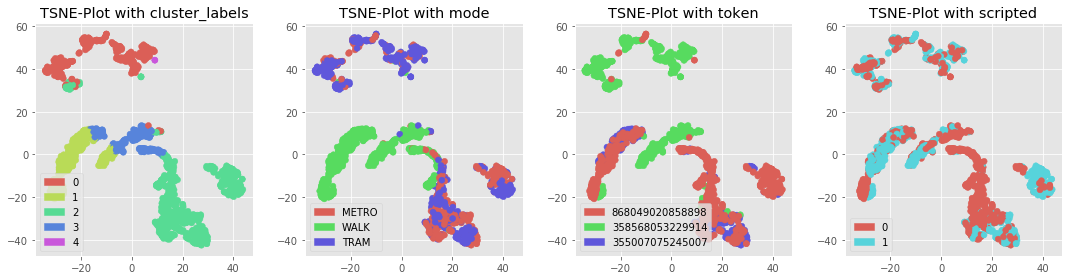

In [19]:
color_encodings = distance_matrix.loc[:,["cluster_labels","mode","token","scripted"]]
plot_2D_tsne_with_coloring_per_targets(features_used, color_encodings, perplexity=50, learning_rate=500)

## Inspect the distribution of modes to cluster label for all trips

From this we can see that it the clustering is not distinct between "WALK" and "TRAM"

In [14]:
mode_dist_df = get_distribution_of_cluster_labels_for("mode", distance_matrix)
mode_dist_df

count_cluster_0  count_cluster_1  count_cluster_2  count_cluster_3  \
0            116.0              0.0            352.0              9.0   
1              4.0            379.0             78.0            232.0   
2            301.0              0.0            356.0              2.0   

   count_cluster_4   mode  
0              0.0  METRO  
1              0.0   WALK  
2              2.0   TRAM

### Plot distribution of cluster labels for transport modes

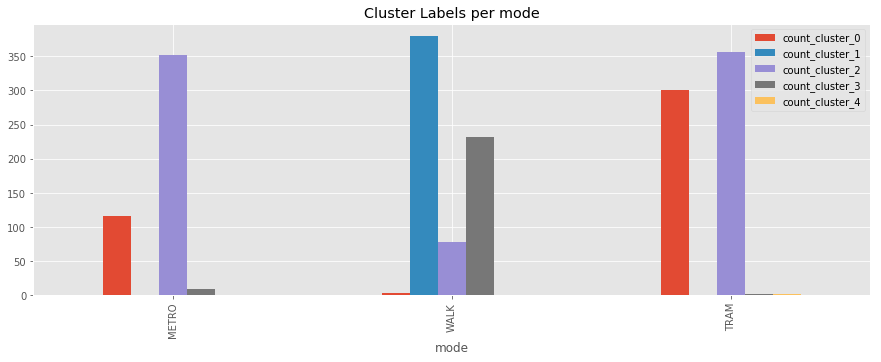

In [15]:
plot_distribution_of_cluster_labels_for_target("mode", distance_matrix)

### Plot distribution of cluster labels for scripted and ordinary


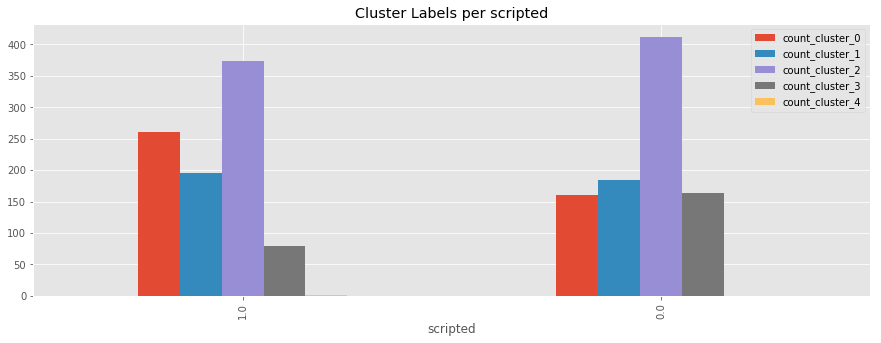

In [18]:
plot_distribution_of_cluster_labels_for_target("scripted", distance_matrix)

### Plot distribution of cluster labels for tokens

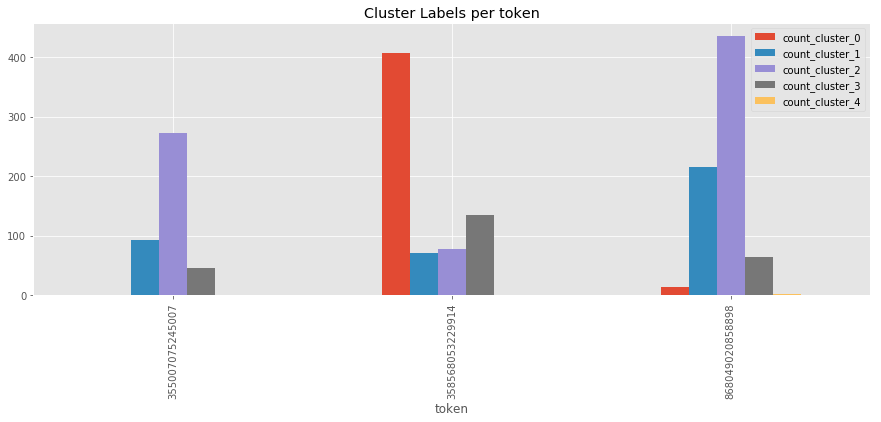

In [16]:
plot_distribution_of_cluster_labels_for_target("token", distance_matrix)

------
## Plot all trips with their clustering labels

C:\Users\Lukas\.conda\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



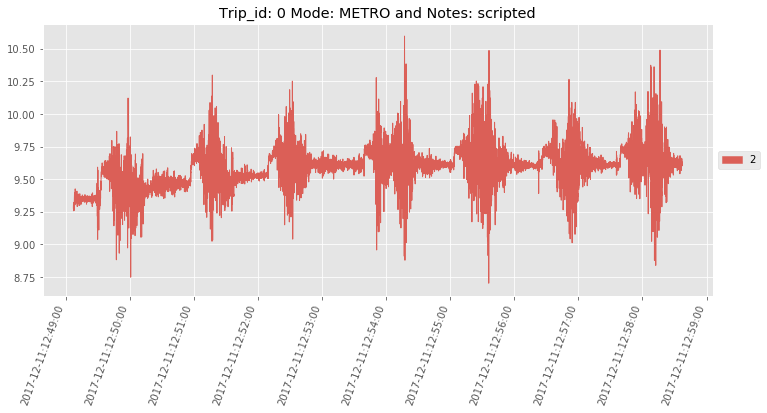

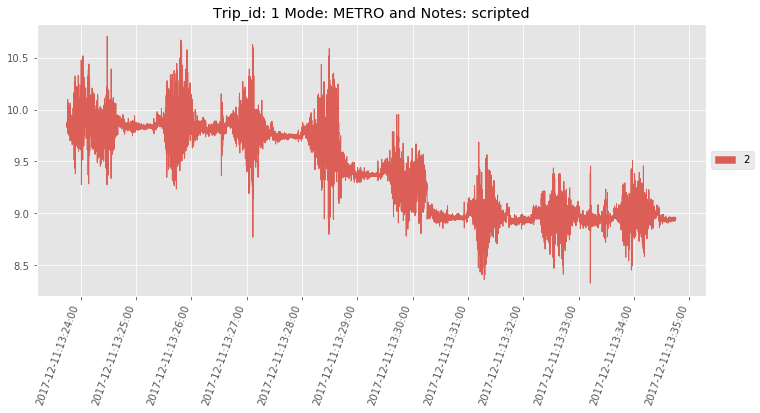

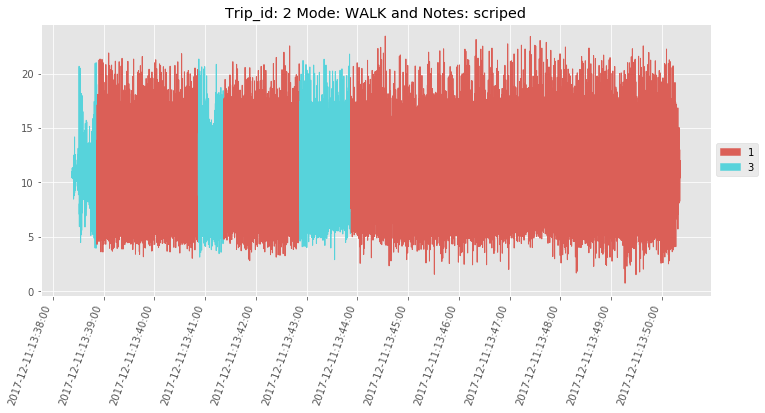

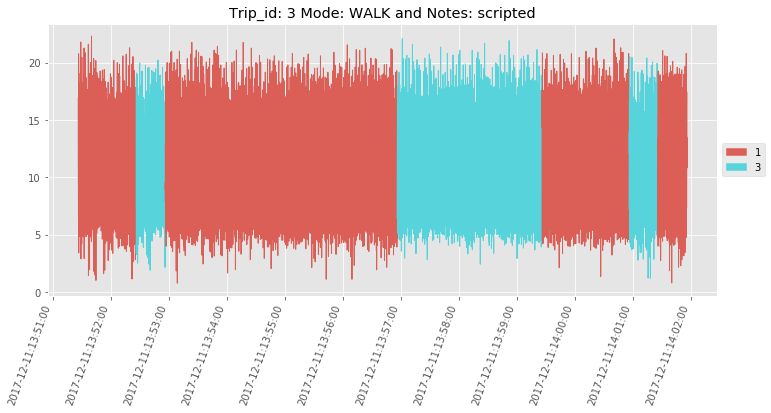

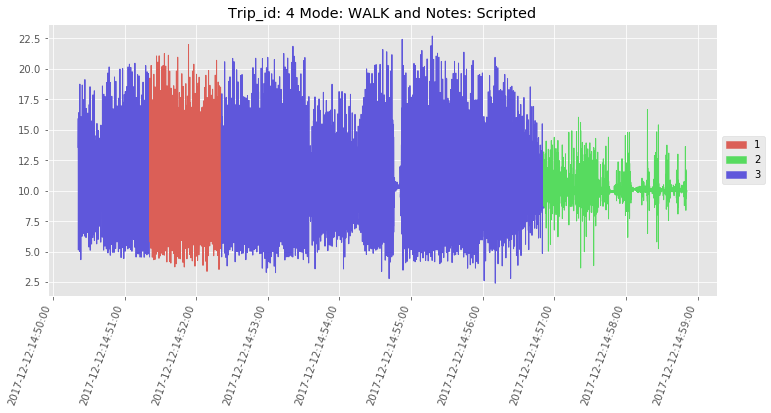

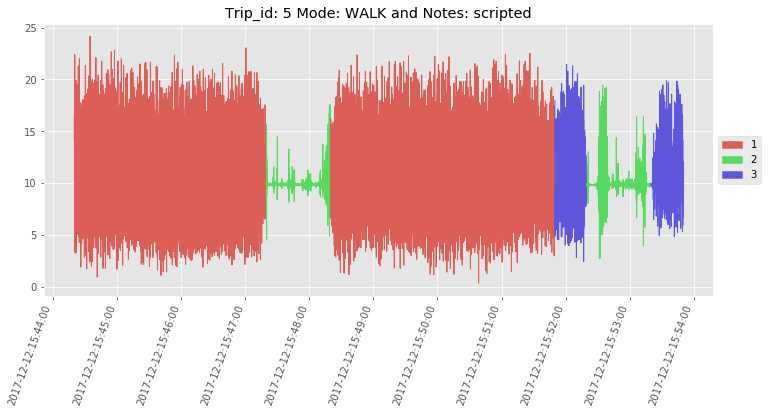

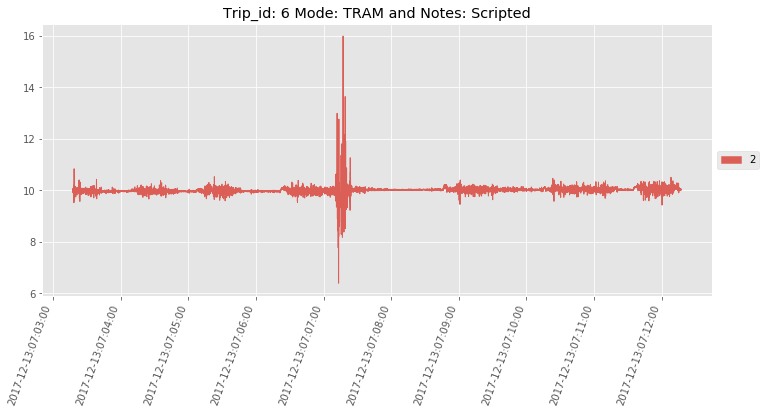

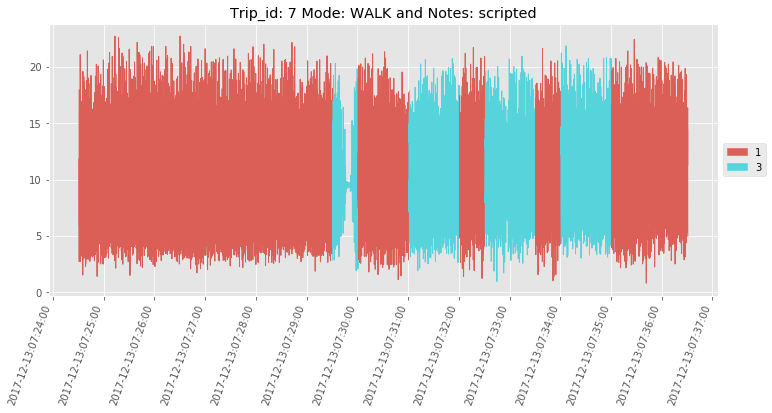

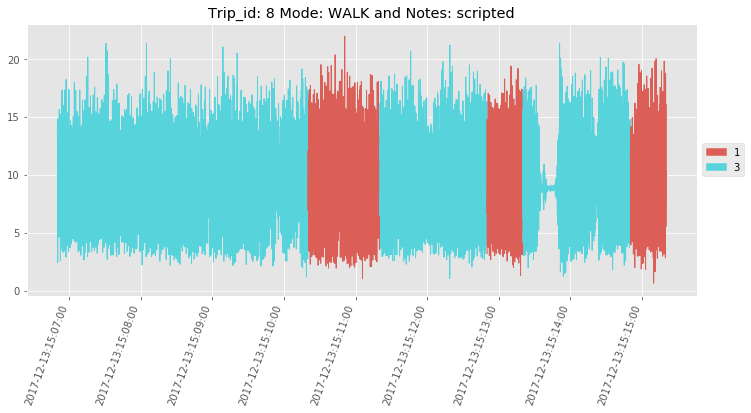

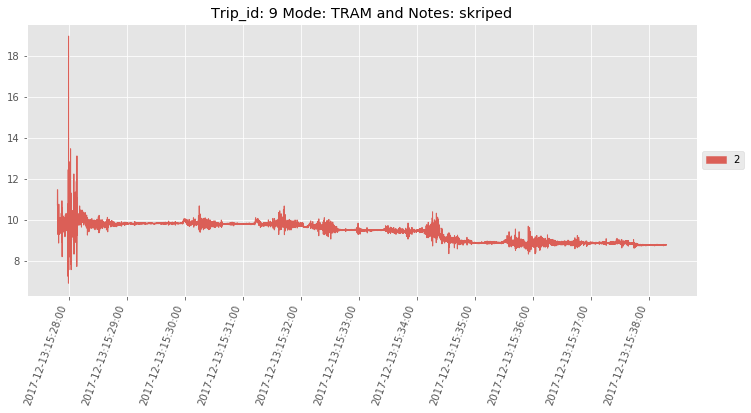

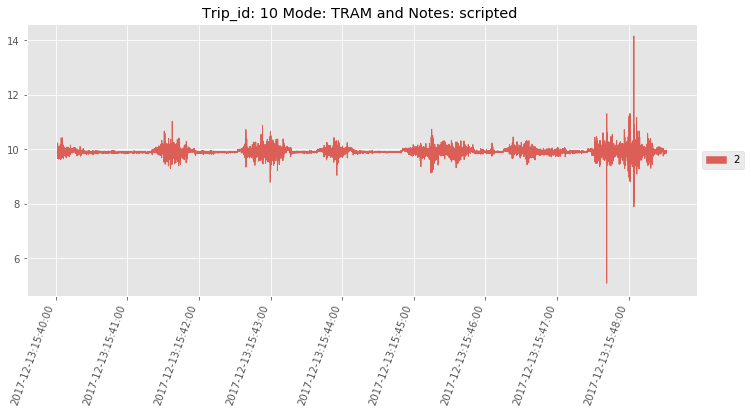

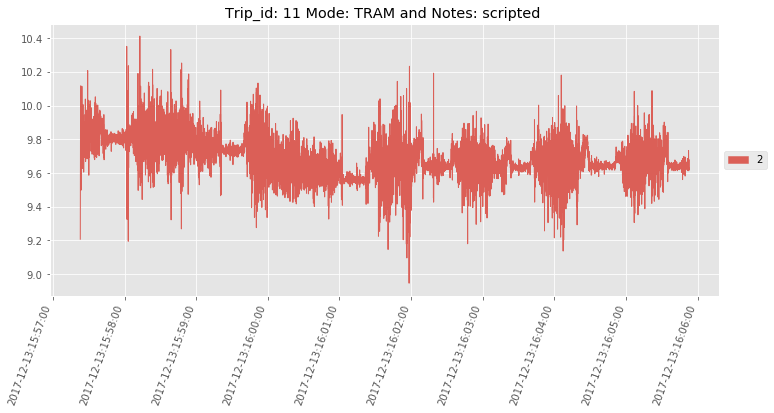

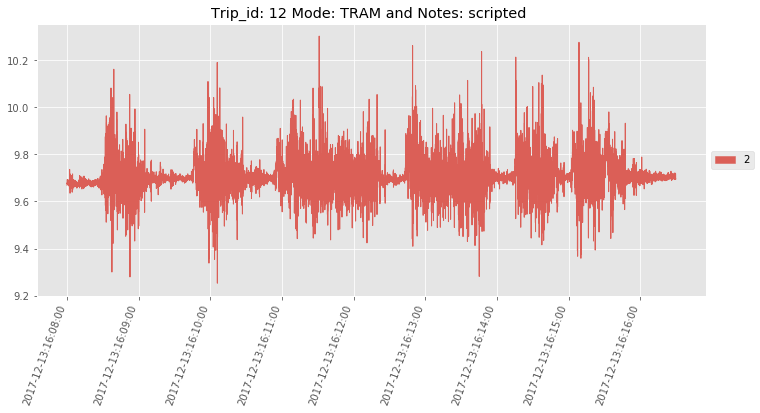

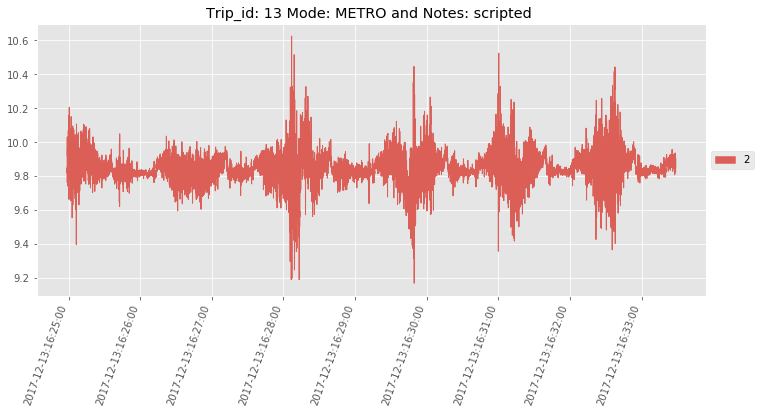

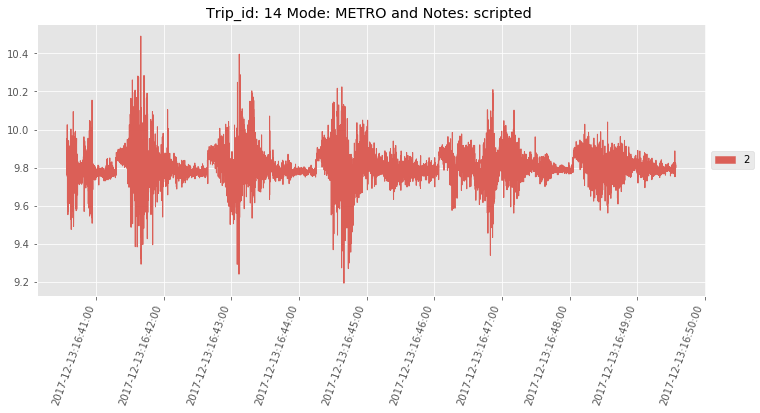

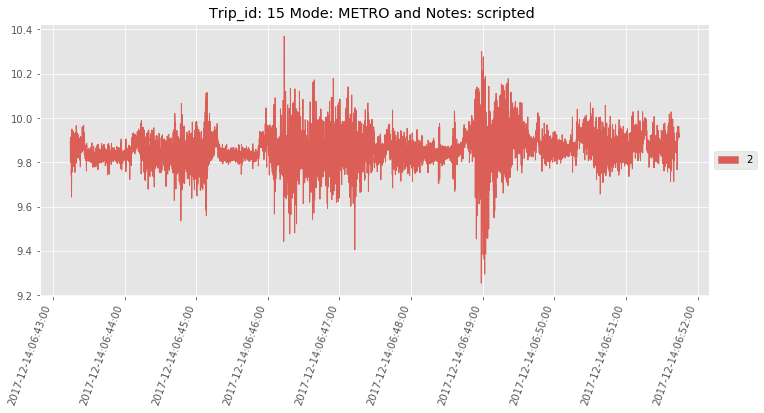

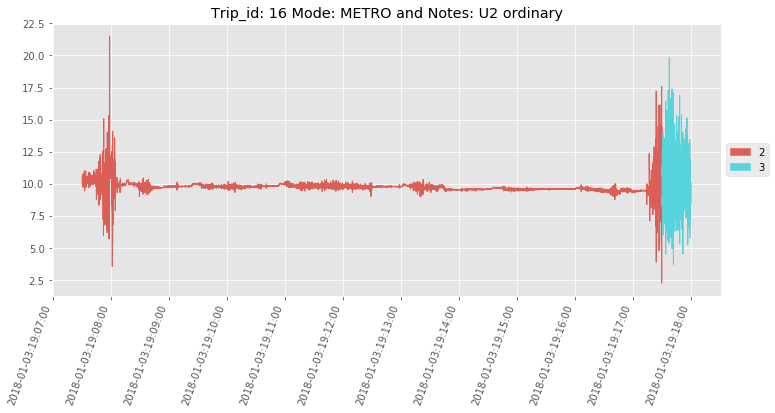

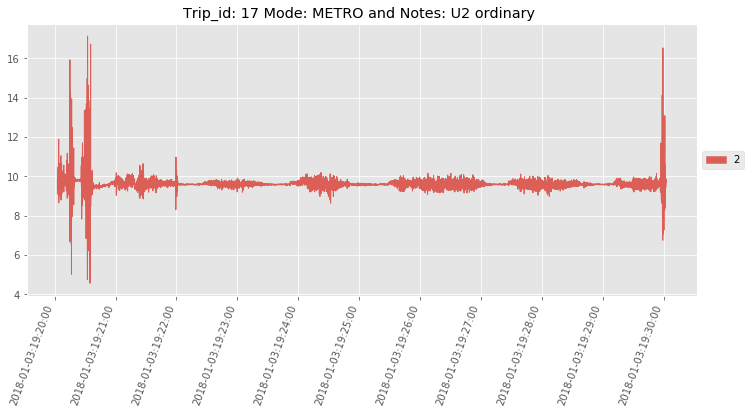

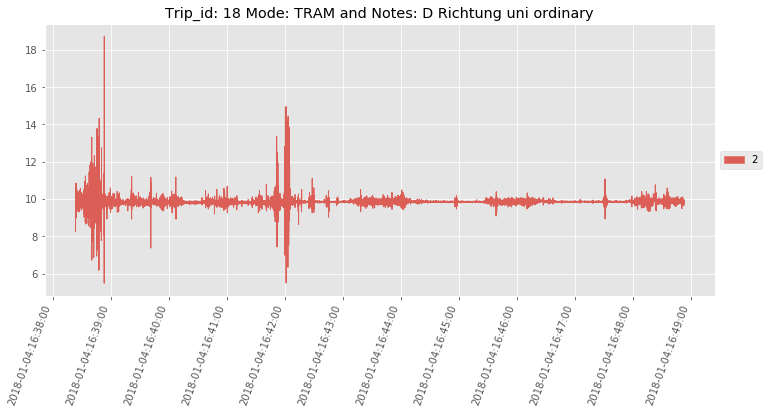

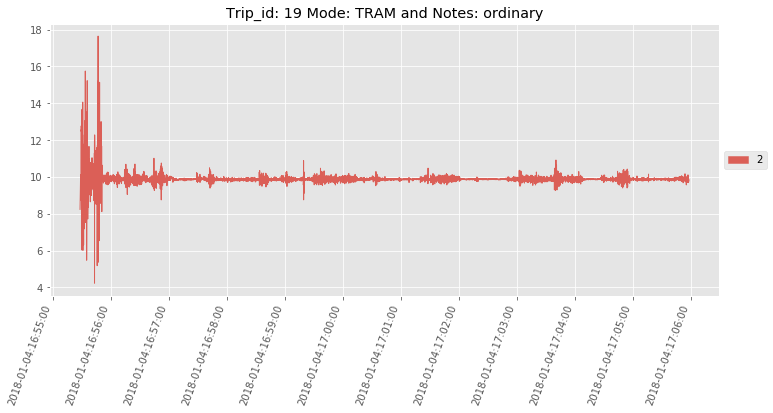

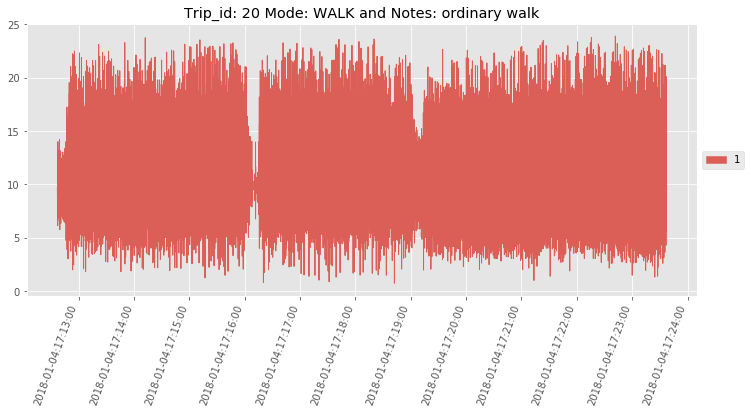

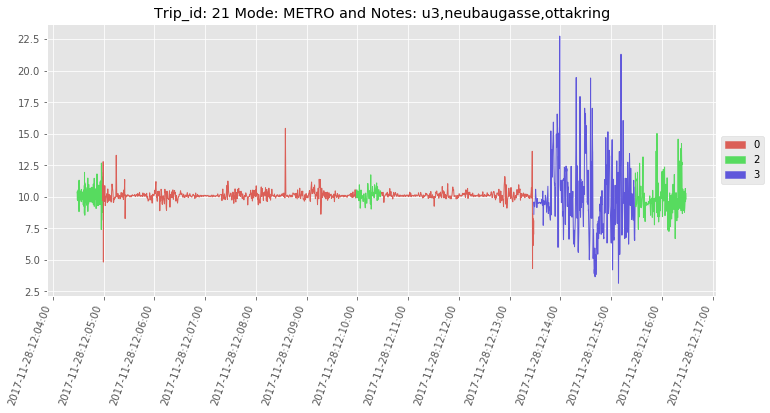

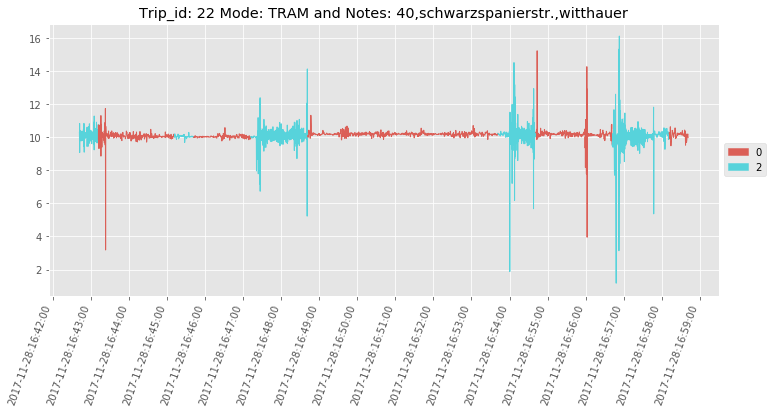

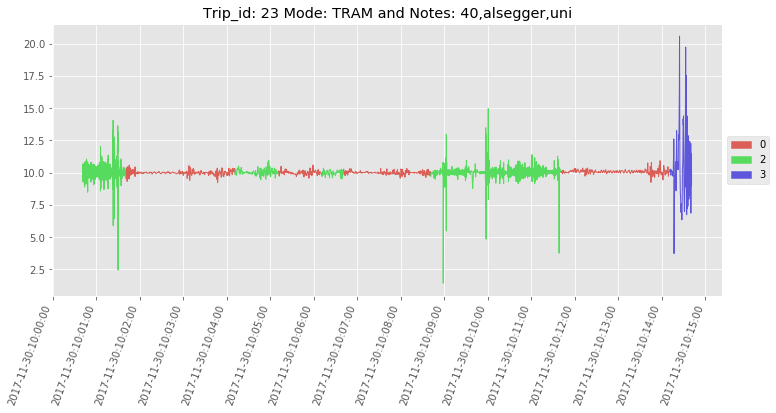

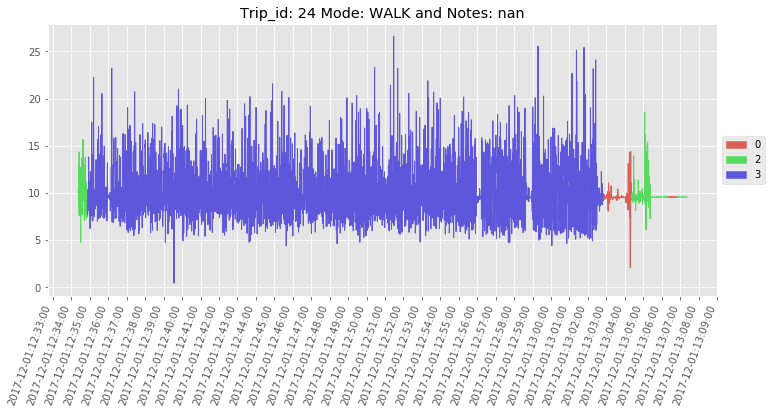

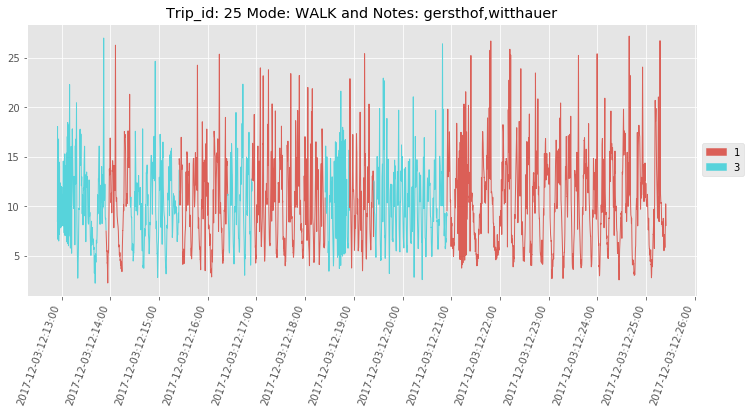

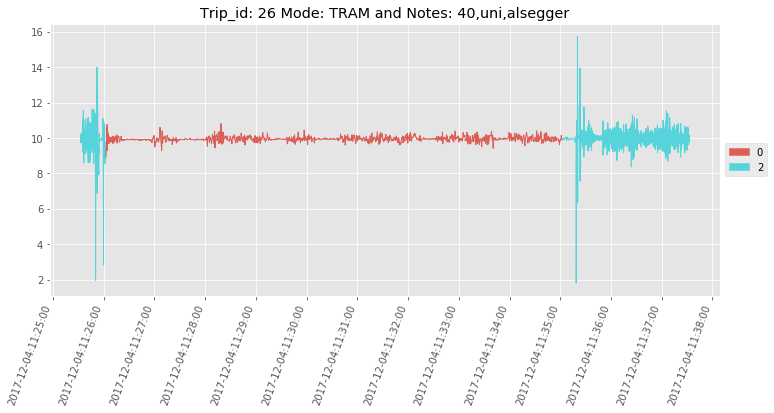

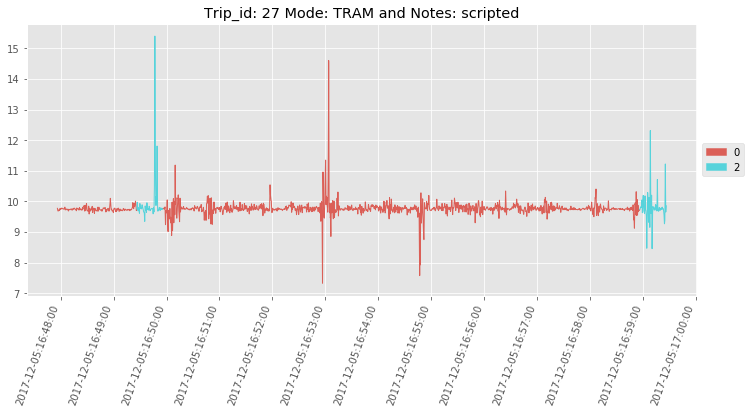

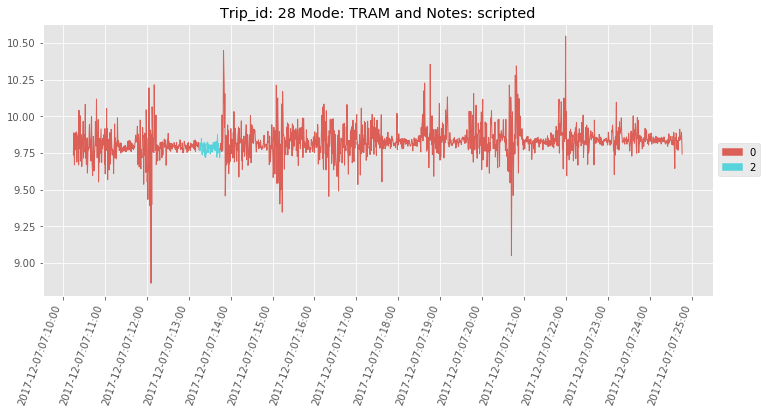

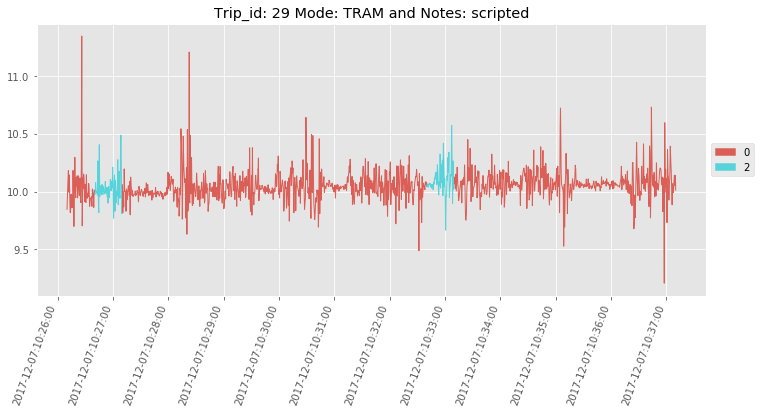

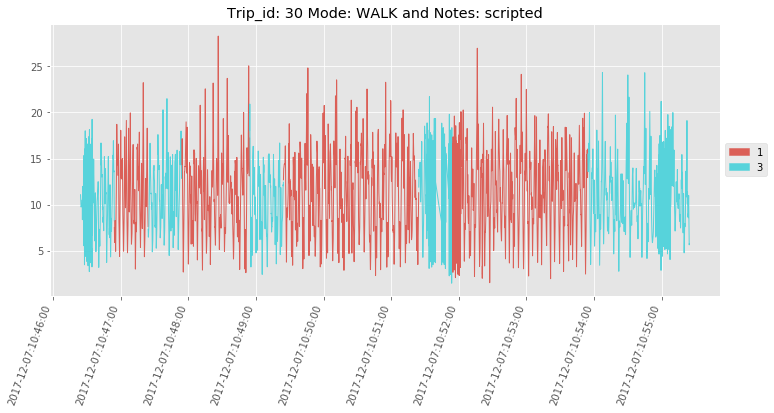

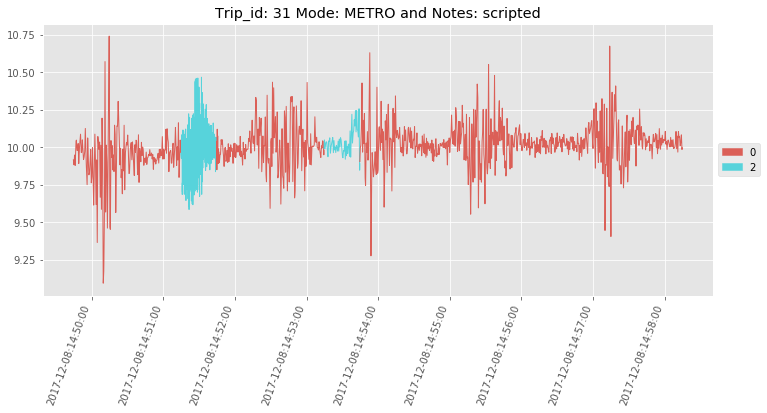

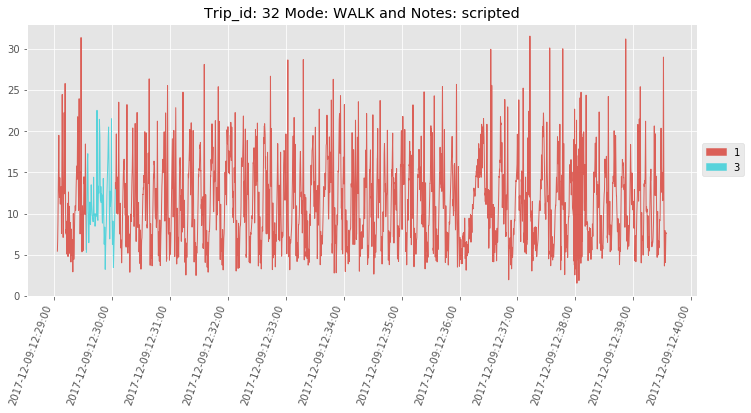

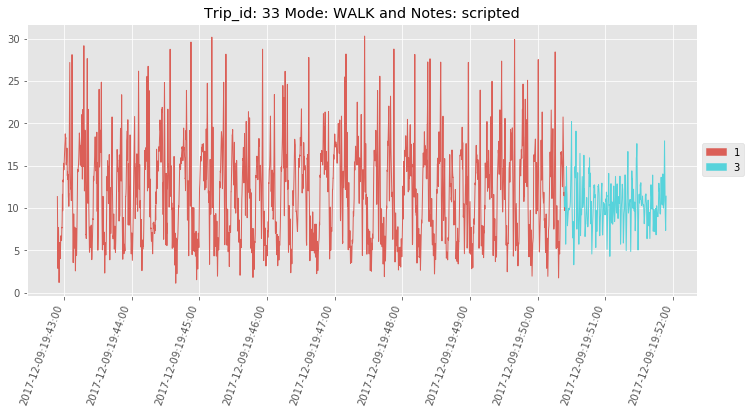

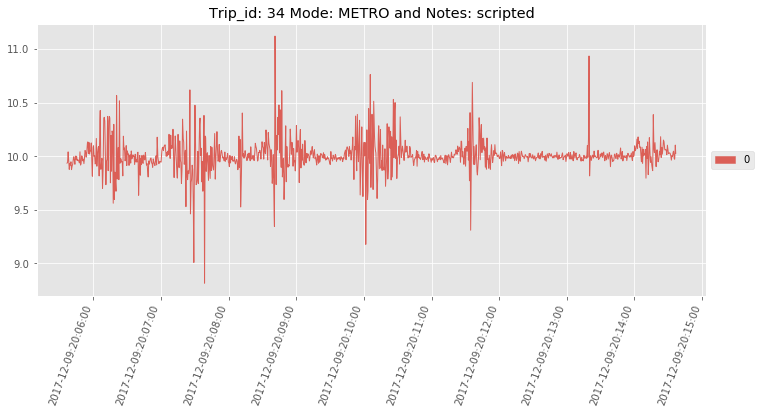

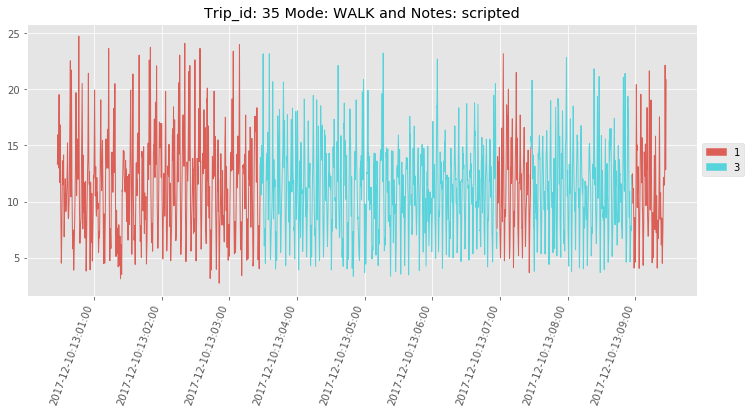

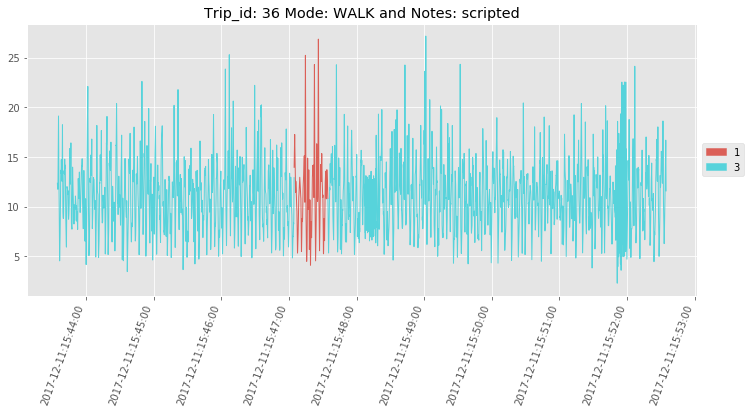

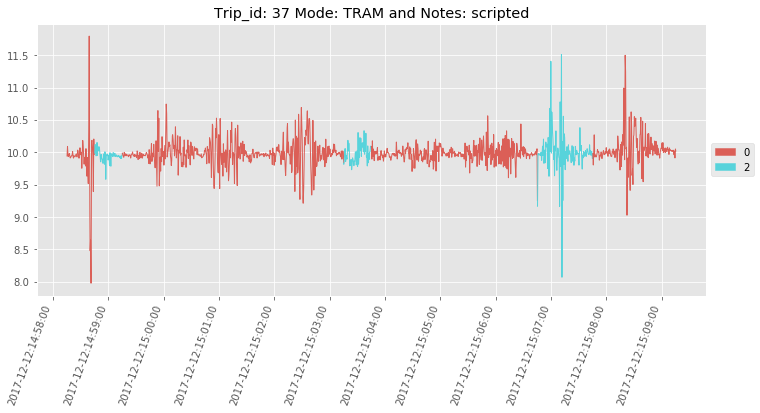

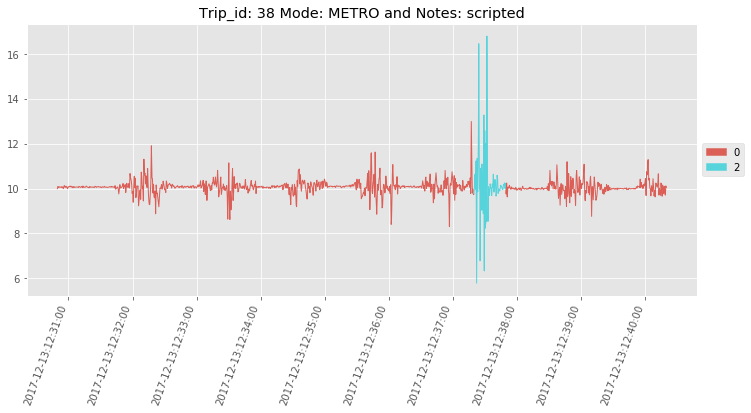

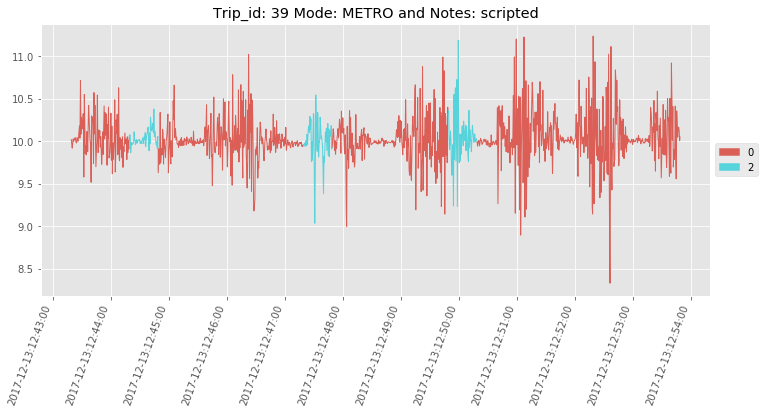

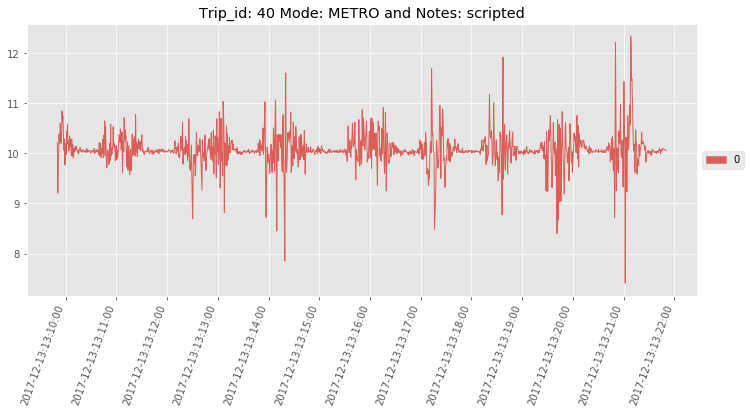

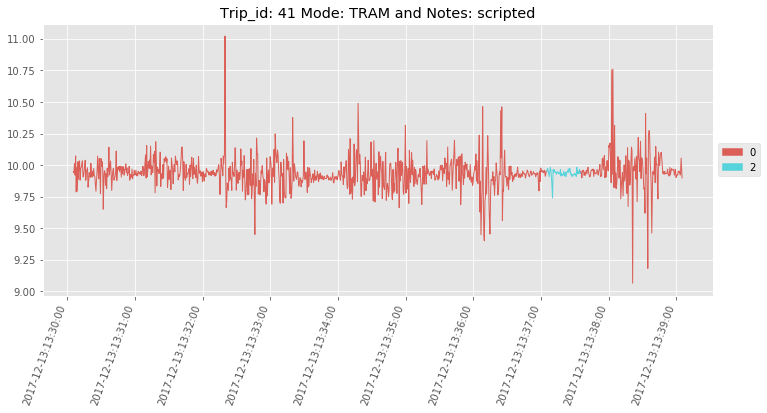

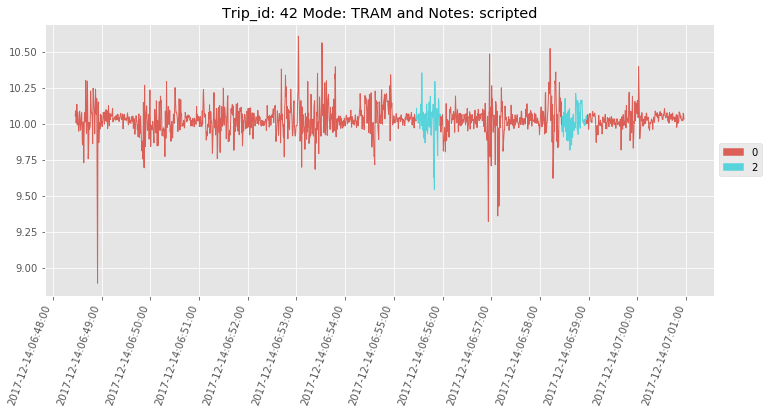

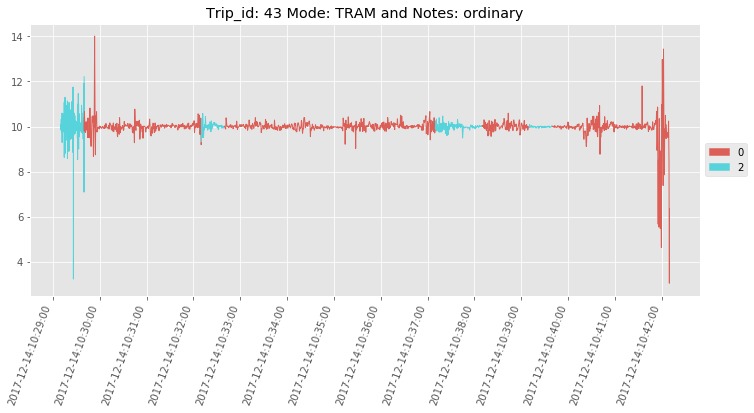

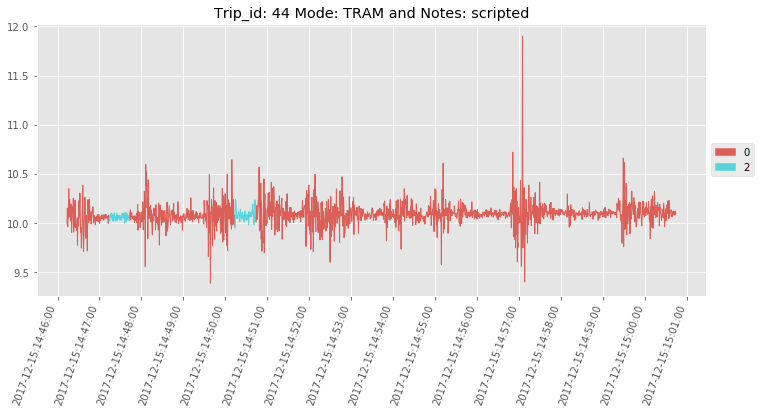

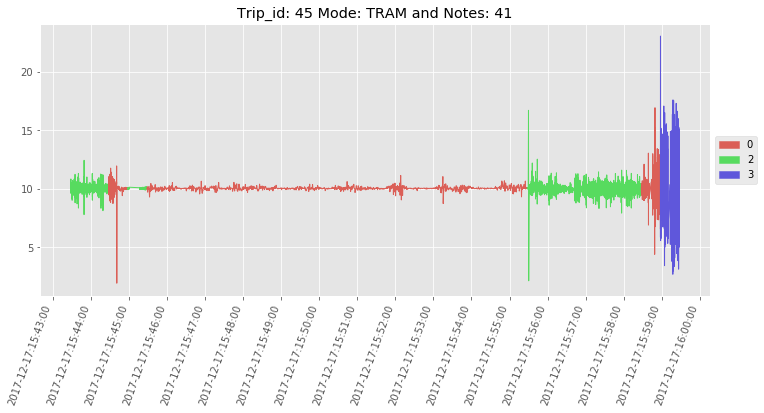

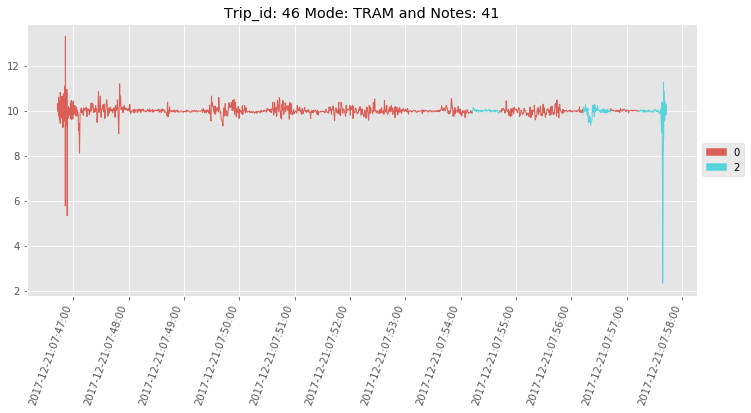

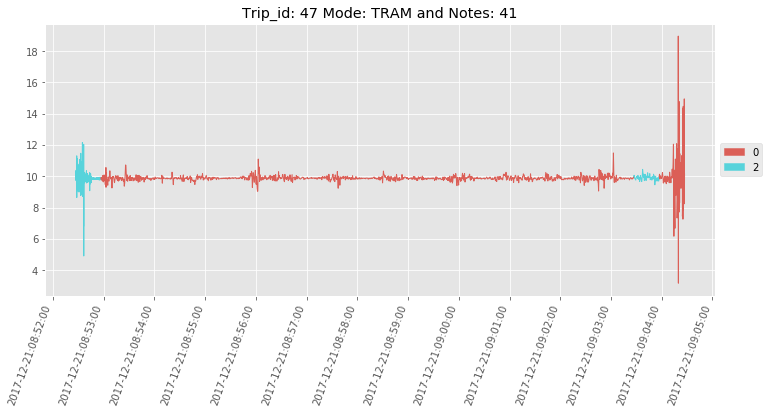

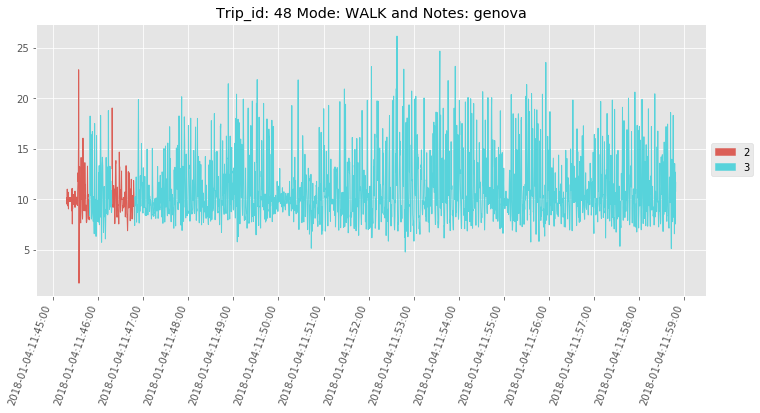

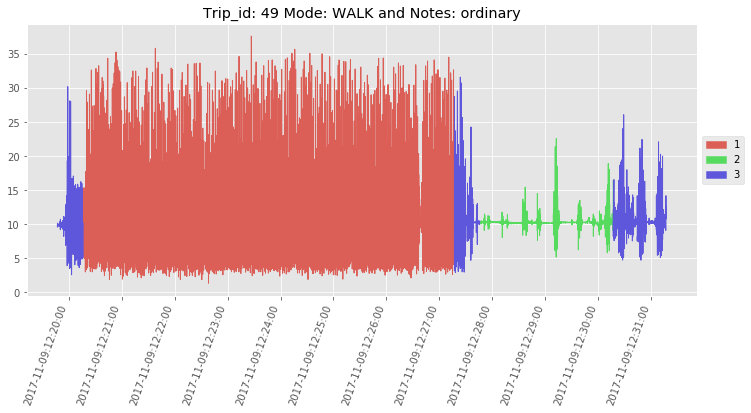

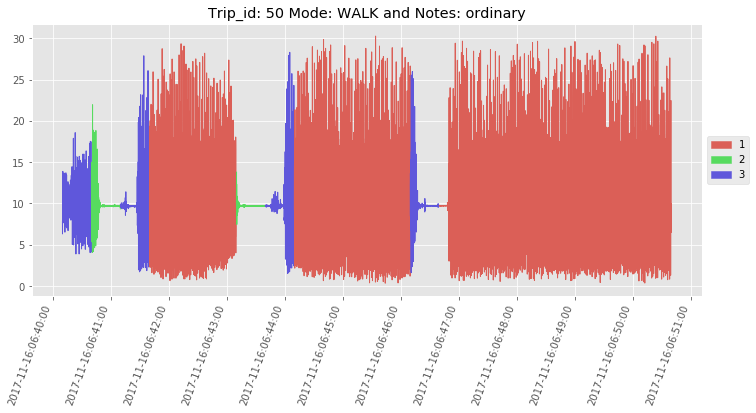

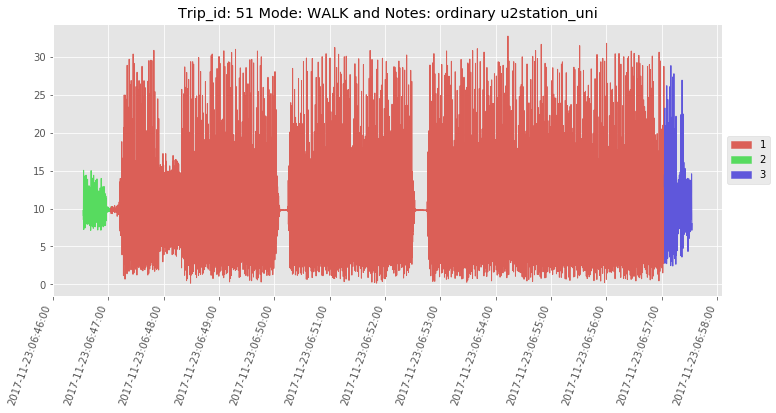

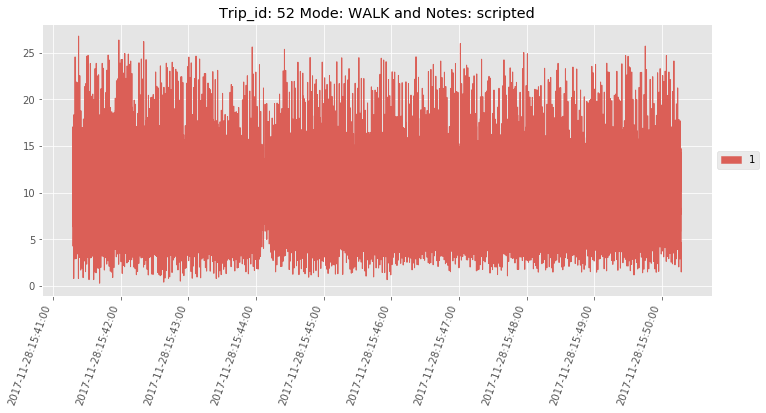

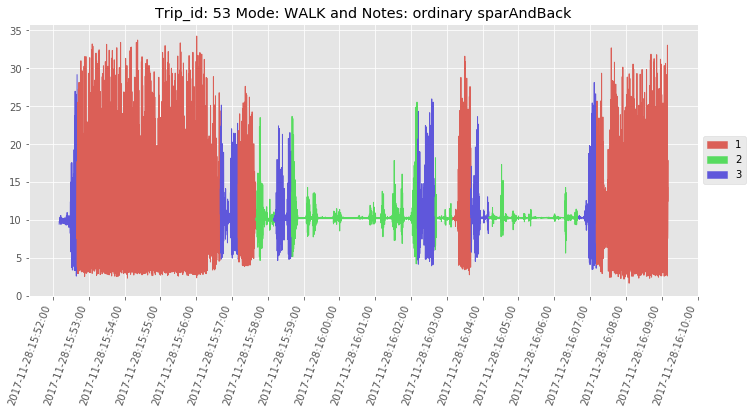

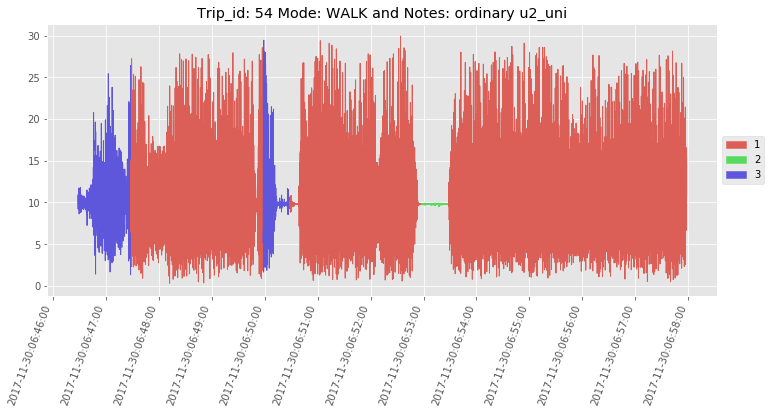

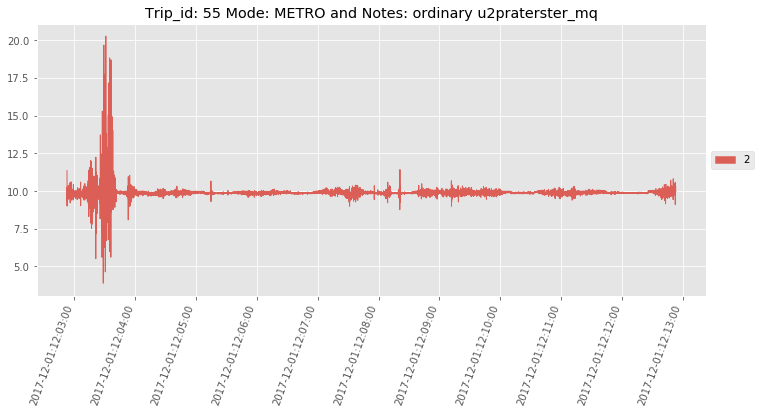

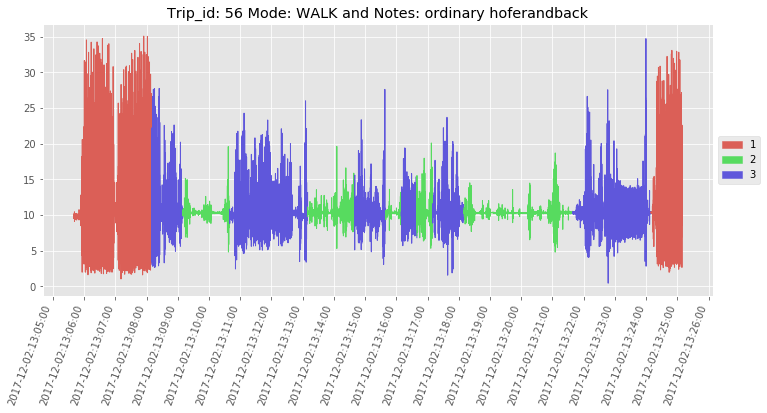

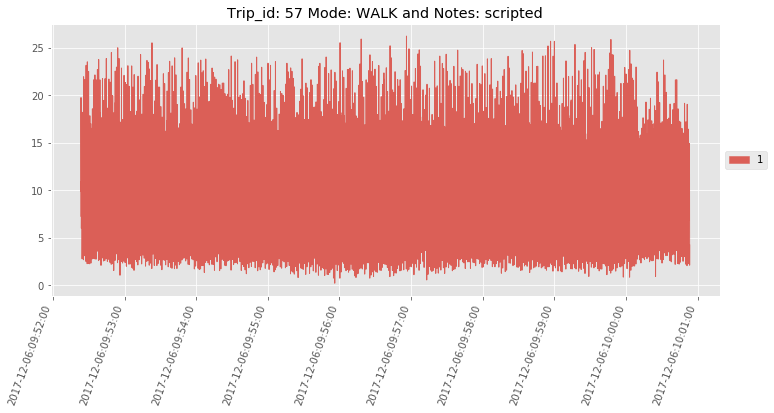

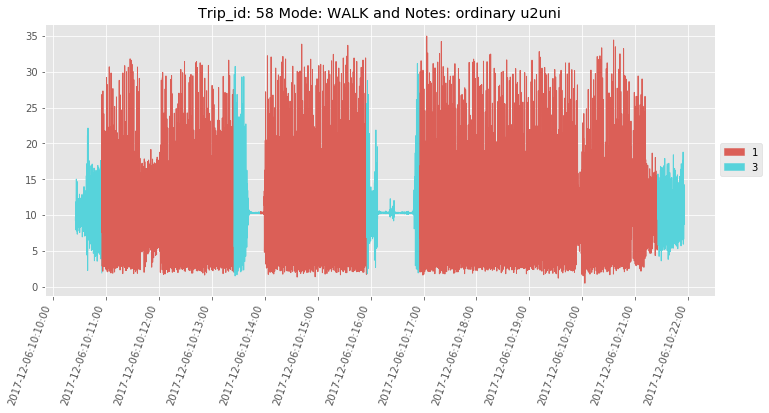

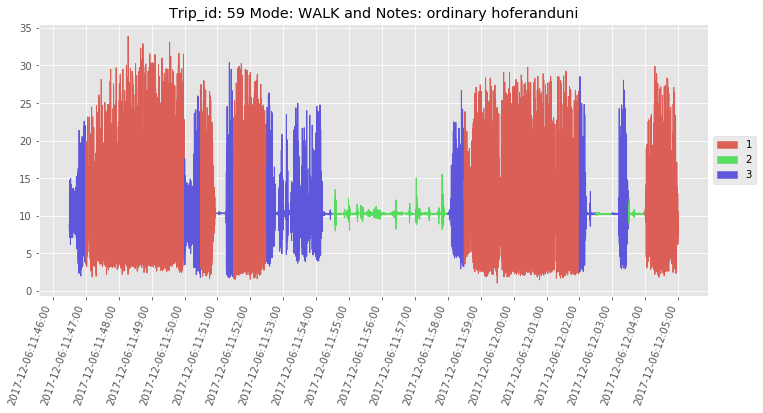

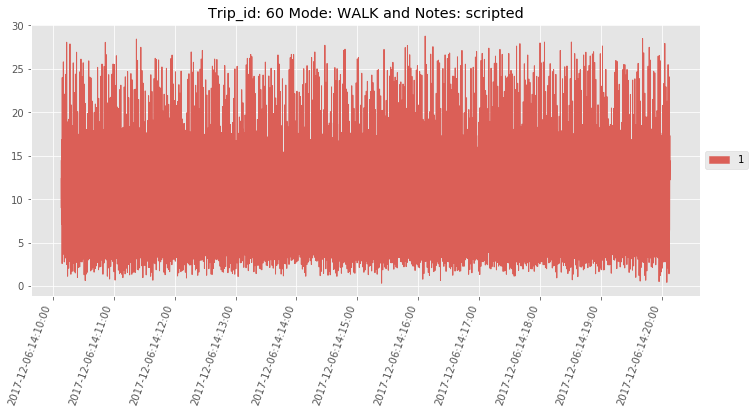

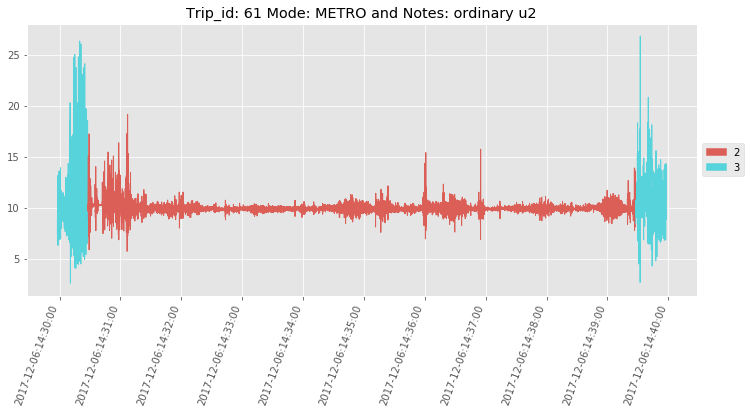

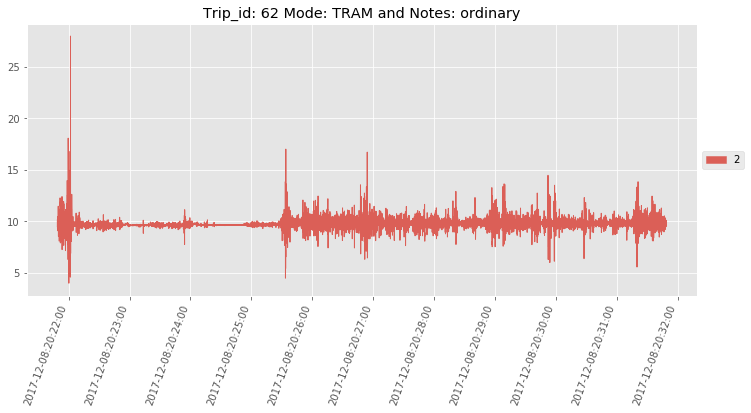

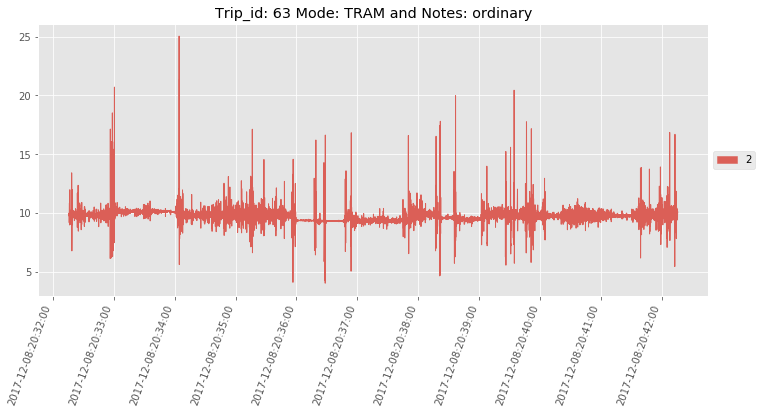

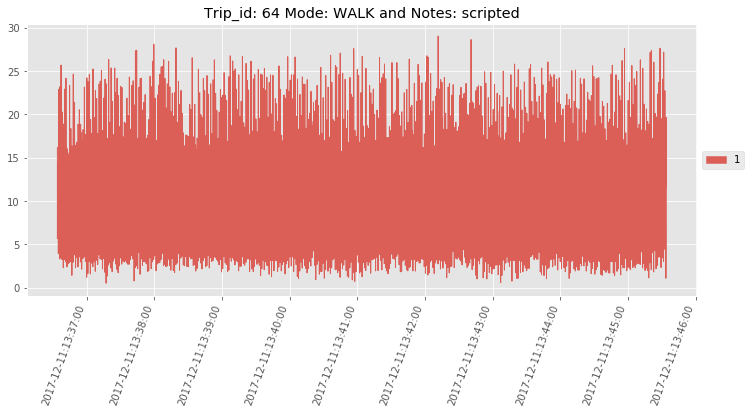

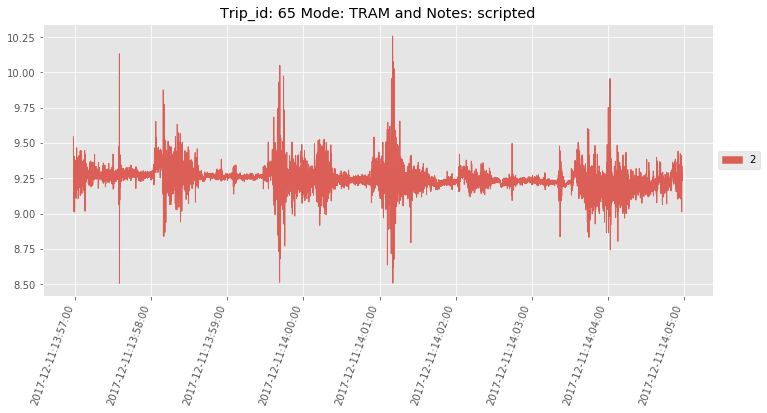

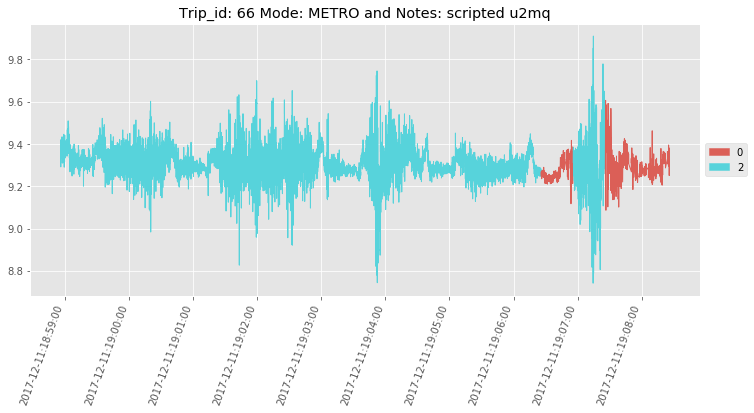

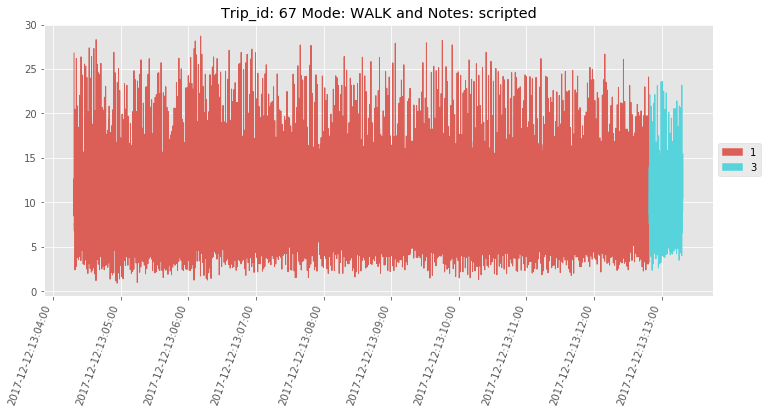

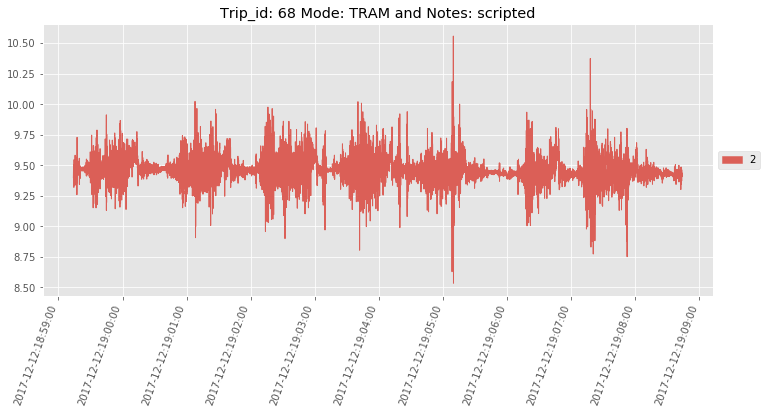

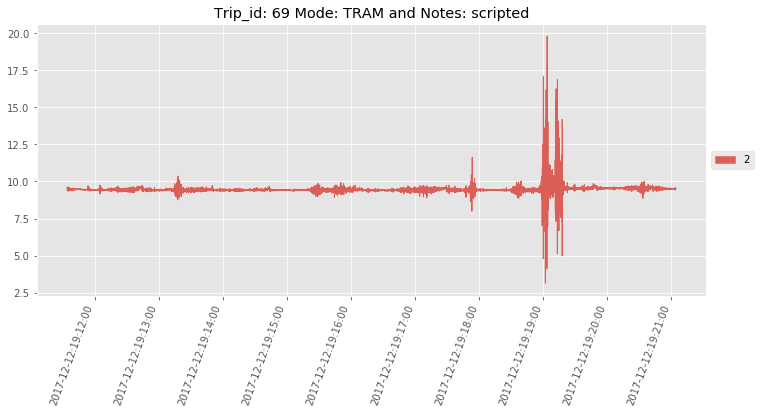

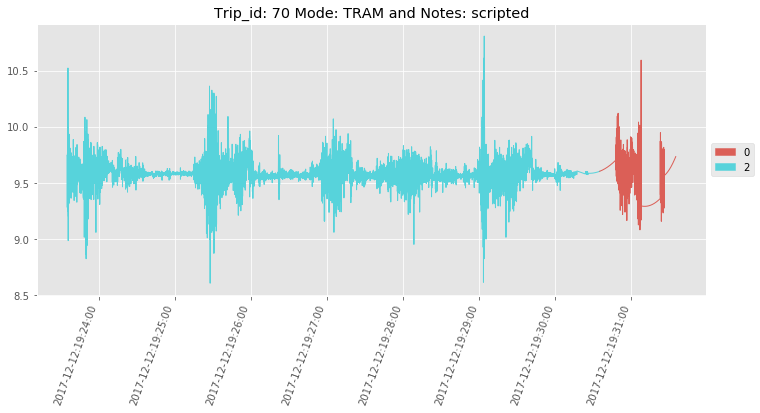

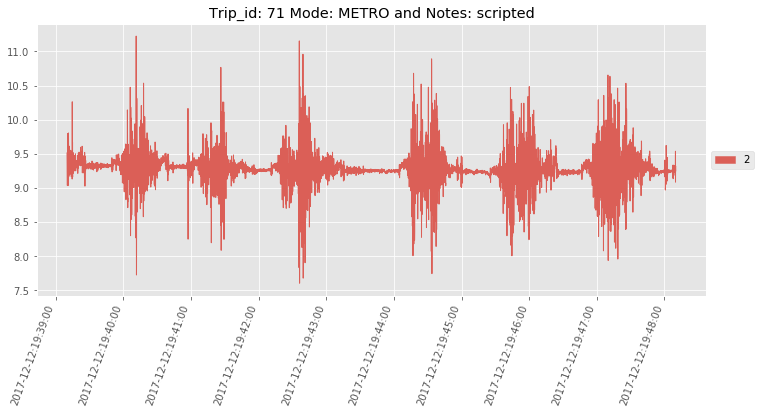

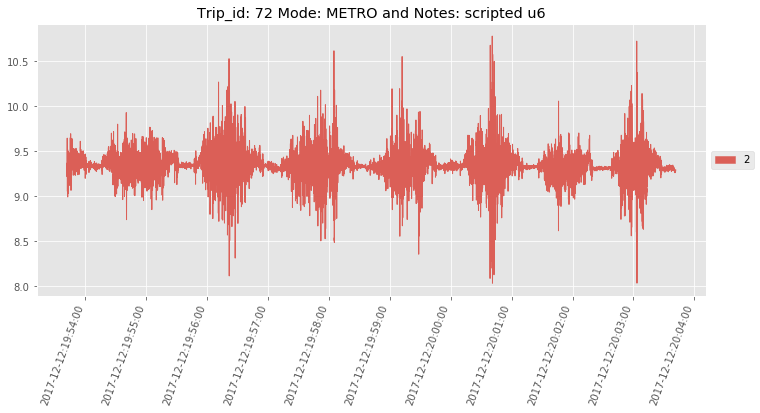

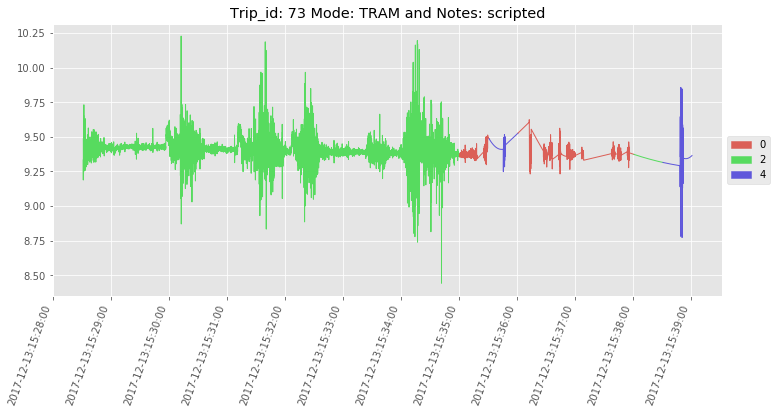

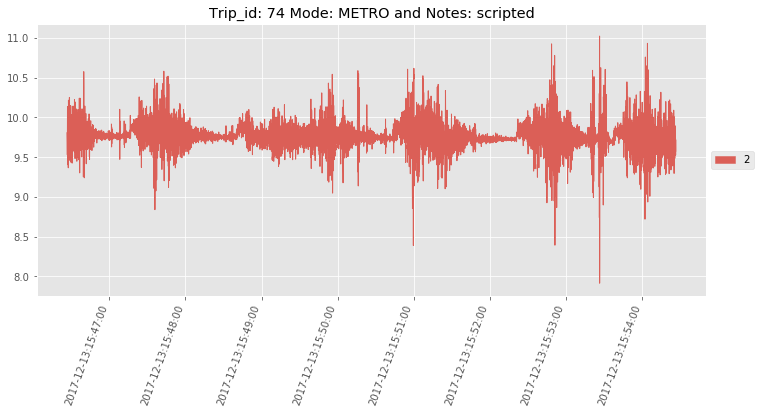

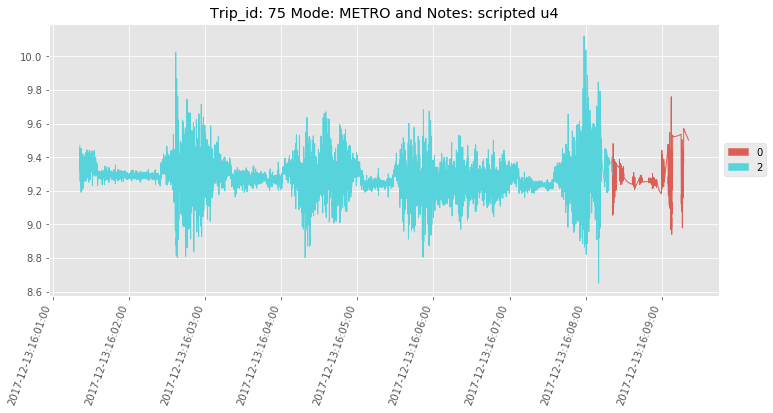

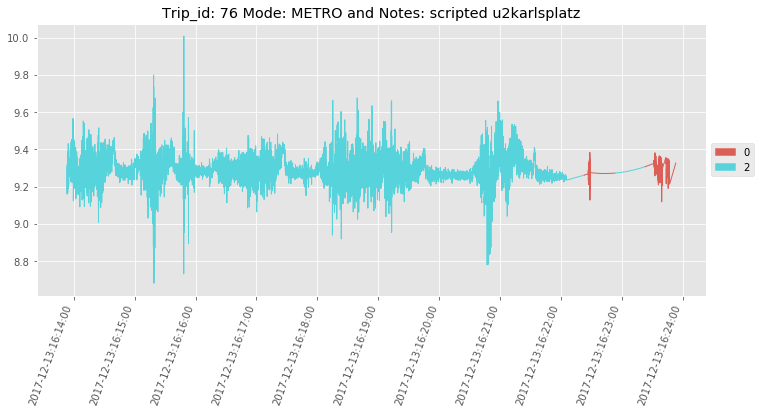

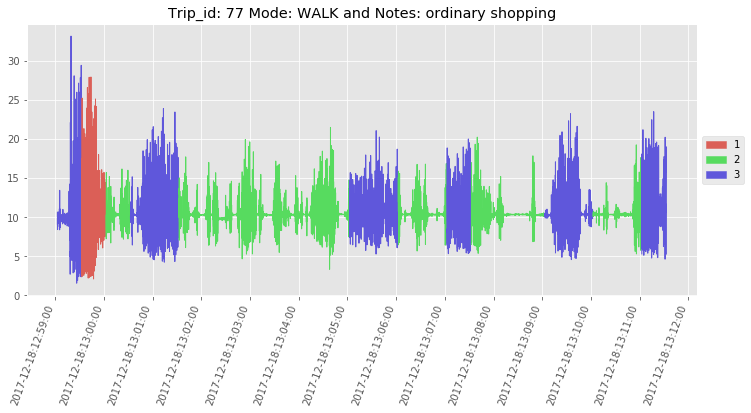

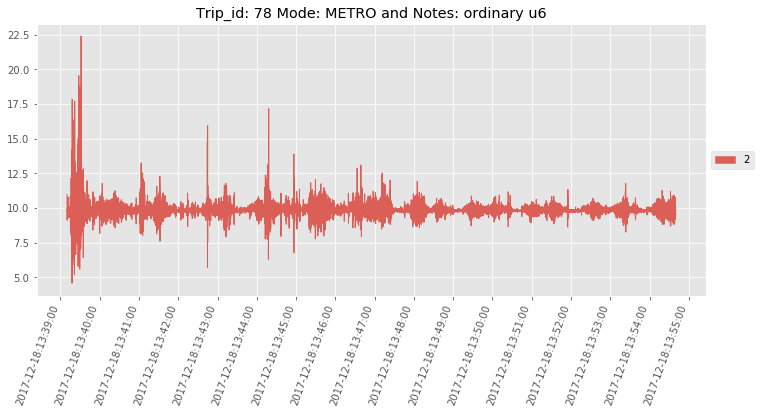

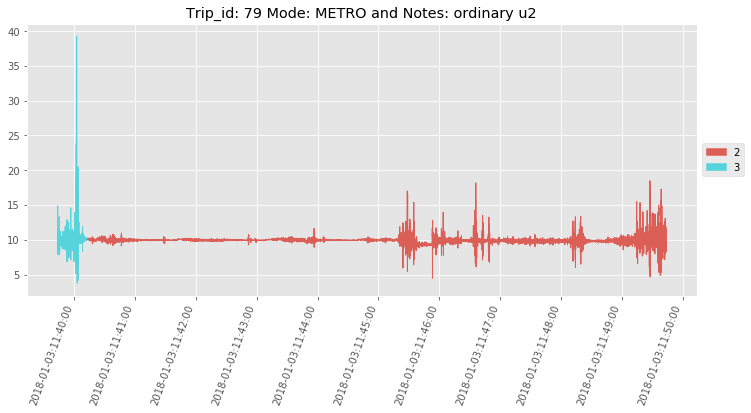

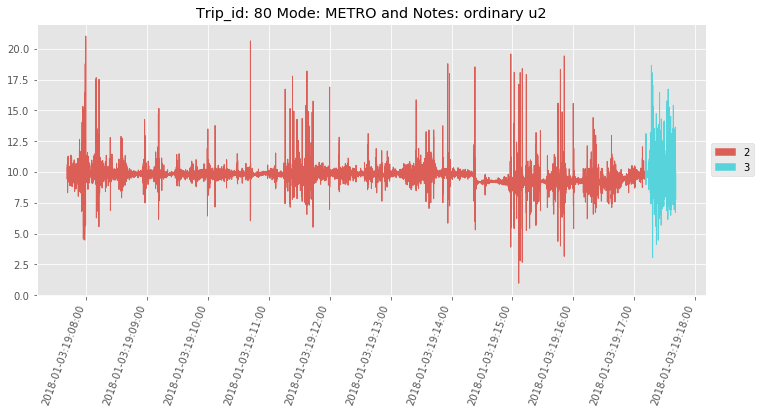

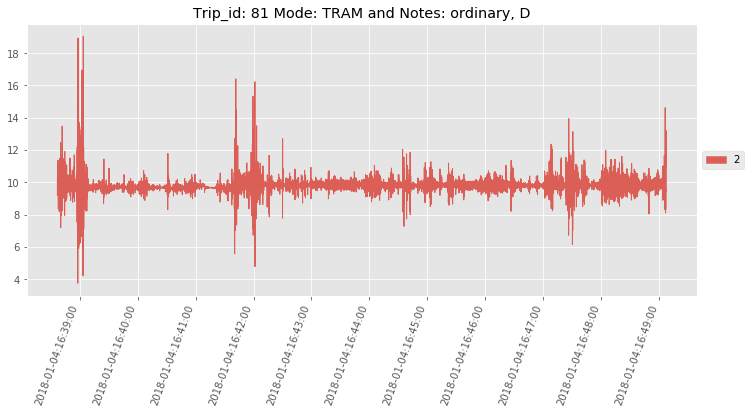

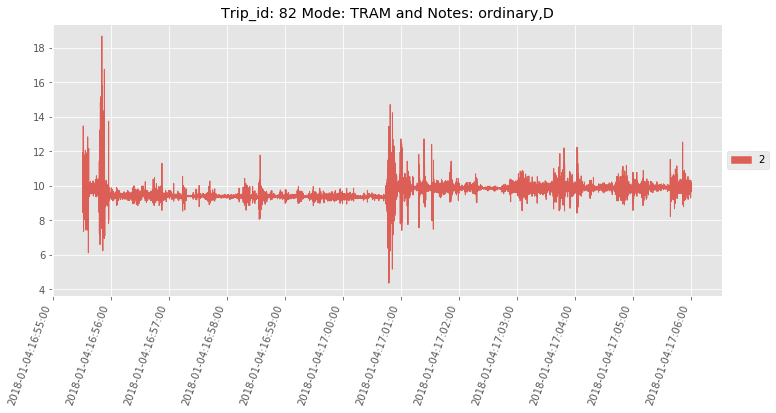

In [17]:
if plot_all_trips:
    trips_unpacked = Preprocessor.unpack_all_trips(dfs)
    plot_all_trips_with_cluster_coloring(trips_unpacked, distance_matrix)